In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/spaceship-titanic/sample_submission.csv
/kaggle/input/spaceship-titanic/train.csv
/kaggle/input/spaceship-titanic/test.csv


In [2]:
from IPython.display import clear_output
!pip3 install -U lazypredict
!pip3 install -U pandas #Upgrading pandas

In [3]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import plotly.express as px
import plotly.graph_objects as go
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold, train_test_split


from lightgbm import LGBMClassifier
import lazypredict
from lazypredict.Supervised import LazyClassifier

import time
import warnings
warnings.filterwarnings('ignore')

In [4]:
train=pd.read_csv('/kaggle/input/spaceship-titanic/train.csv')
test=pd.read_csv('/kaggle/input/spaceship-titanic/test.csv')
sample=pd.read_csv('/kaggle/input/spaceship-titanic/sample_submission.csv')

# 1. How big is the data?

In [5]:
print(f'\033[94mNumber of rows in train data: {train.shape[0]}')
print(f'\033[94mNumber of columns in train data: {train.shape[1]}')
print(f'\033[94mNumber of values in train data: {train.count().sum()}')
print(f'\033[94mNumber missing values in train data: {sum(train.isna().sum())}')

Number of rows in train data: 8693
Number of columns in train data: 14
Number of values in train data: 119378
Number missing values in train data: 2324


# 2. How does the data look like?

In [6]:
train.sample(5)

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
6937,7359_01,Earth,False,E/492/S,PSO J318.5-22,21.00,False,0.00,434.00,0.00,75.00,135.00,Ellana Jenson,True
7708,8225_01,Mars,False,NaN,TRAPPIST-1e,15.00,False,85.00,0.00,1130.00,0.00,248.00,Heersh Nutty,False
648,0680_02,Earth,True,G/105/P,TRAPPIST-1e,7.00,False,0.00,0.00,0.00,0.00,0.00,Annard Garnes,False
6362,6729_02,Europa,True,A/82/S,55 Cancri e,48.00,False,0.00,0.00,0.00,0.00,0.00,Izarkar Dedometeel,True
7713,8229_01,Earth,True,G/1336/P,TRAPPIST-1e,15.00,False,0.00,0.00,0.00,0.00,0.00,Armene Patthews,True


* Transported is the target variable

# 3. What is the data type of cols?

In [7]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8693 entries, 0 to 8692
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   PassengerId   8693 non-null   object 
 1   HomePlanet    8492 non-null   object 
 2   CryoSleep     8476 non-null   object 
 3   Cabin         8494 non-null   object 
 4   Destination   8511 non-null   object 
 5   Age           8514 non-null   float64
 6   VIP           8490 non-null   object 
 7   RoomService   8512 non-null   float64
 8   FoodCourt     8510 non-null   float64
 9   ShoppingMall  8485 non-null   float64
 10  Spa           8510 non-null   float64
 11  VRDeck        8505 non-null   float64
 12  Name          8493 non-null   object 
 13  Transported   8693 non-null   bool   
dtypes: bool(1), float64(6), object(7)
memory usage: 891.5+ KB


# 4. Are there any missing values?

### except PassengerID and transported, all columns have null values
### But no worries, all are less than 2.5%, we will deal them later

In [8]:
(train.isnull().sum()/train.shape[0]*100).sort_values(ascending=False)

CryoSleep      2.50
ShoppingMall   2.39
VIP            2.34
HomePlanet     2.31
Name           2.30
Cabin          2.29
VRDeck         2.16
FoodCourt      2.11
Spa            2.11
Destination    2.09
RoomService    2.08
Age            2.06
PassengerId    0.00
Transported    0.00
dtype: float64

<AxesSubplot:>

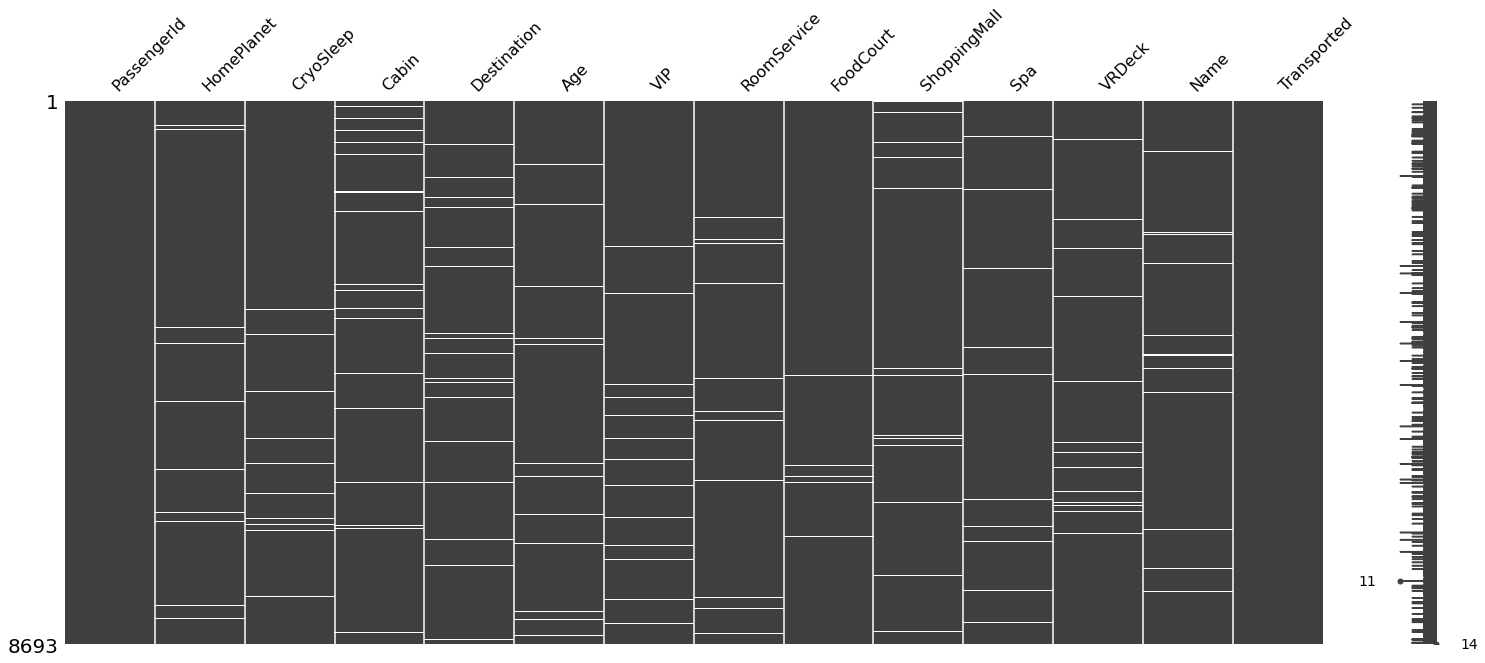

In [9]:
import missingno as msno
msno.matrix(train)

<AxesSubplot:>

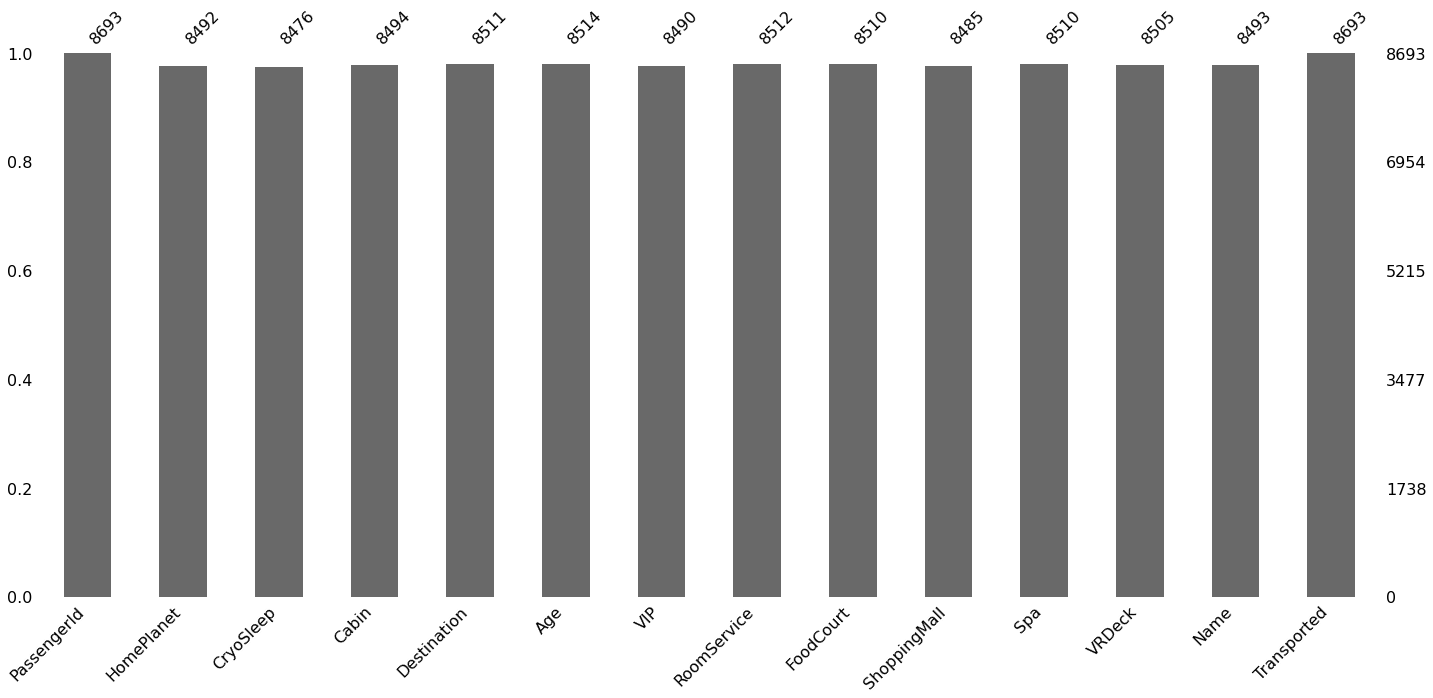

In [10]:
msno.bar(train)

# 5. How does the data look mathematically?

In [11]:
train.describe()

,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck
count,8514.00,8512.00,8510.00,8485.00,8510.00,8505.00
mean,28.83,224.69,458.08,173.73,311.14,304.85
std,14.49,666.72,1611.49,604.70,1136.71,1145.72
min,0.00,0.00,0.00,0.00,0.00,0.00
25%,19.00,0.00,0.00,0.00,0.00,0.00
50%,27.00,0.00,0.00,0.00,0.00,0.00
75%,38.00,47.00,76.00,27.00,59.00,46.00
max,79.00,14327.00,29813.00,23492.00,22408.00,24133.00


* Minimum age is zero? Looks odd to me
* Out of all services, FOOD court bill is high, shopping bill is less(for a obvious reasons in space)
* But it seems some people have never spent a penny on any service.Is it because of cryosleep.We never know!!!50% of the people didn't spend a penny
* The average age of passengers on board is 29, the oldest passenger is 79 years old
* The average cost of passengers for the use of shopping mall is 174, and the maximum cost is 23492
* The average cost of passengers for the use of spa is 311, and the maximum cost is 22408
* The average cost of passengers for the use of VR deck is 305, and the maximum cost is 24133
* The average cost of passengers for the use of room services is 225, and the maximum cost is 14327
* The average cost of passengers for the use of food court is 458, and the maximum cost is 29813

## How many passengers have not spent any money?

In [12]:
not_billed_data = train[(train["RoomService"] == 0)
                         & (train["Spa"] == 0)
                         & (train["FoodCourt"] == 0) 
                         & (train["ShoppingMall"] == 0)
                         & (train["VRDeck"] == 0)]

mean_age = not_billed_data["Age"].mean().round()
print("There are {0} passengers on the board of the spaceship who have not spent money, their average age is {1}"
      .format(not_billed_data.shape[0], mean_age))

There are 3247 passengers on the board of the spaceship who have not spent money, their average age is 25.0


# 6. Are there duplicate values?

In [13]:
train.duplicated().sum()

0

Great!!! Zero duplicates!!!

# 7. How is the correlation between cols?

In [14]:
train.corr()['Transported']

Age            -0.08
RoomService    -0.24
FoodCourt       0.05
ShoppingMall    0.01
Spa            -0.22
VRDeck         -0.21
Transported     1.00
Name: Transported, dtype: float64

* People who have spent much on services,thier transportation chances are low
* As Age is going up, chances of transportation is low
* Let's find out in the next section

# Let's visualise to get more insights

# 1. Categorical Data

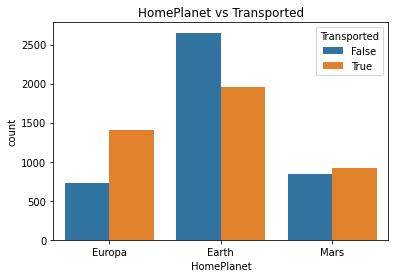

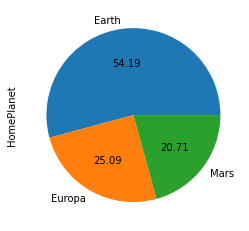

In [15]:
sns.countplot(x=train['HomePlanet'],hue=train['Transported'])
plt.title('HomePlanet vs Transported')
plt.show()
train.HomePlanet.value_counts().plot(kind='pie',autopct='%.2f')
plt.show()

* Passensgers are more from Earth(54.19%)
* Passengers from Europa found to be Transported more where as people from mars almost ~50% chances of transportation

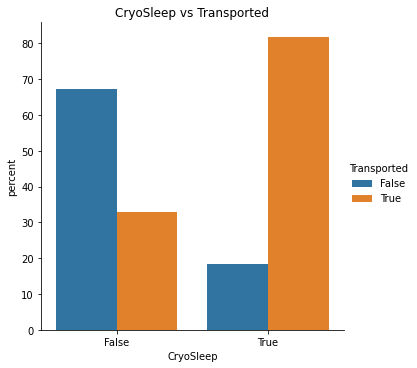

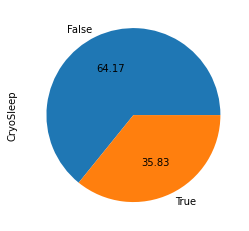

In [16]:
x,y = 'CryoSleep', 'Transported'

(train.groupby(x)[y].value_counts(normalize=True).mul(100).rename('percent').reset_index().pipe((sns.catplot,'data'), x=x,y='percent',hue=y,kind='bar'))
plt.title('CryoSleep vs Transported')
plt.show()
# sns.countplot(x=train['CryoSleep'],hue=train['Transported'])
# plt.title('CryoSleep vs Transported')
# plt.show()
train.CryoSleep.value_counts().plot(kind='pie',autopct='%.2f')
plt.show()

* Whoever under crosleep have 80% chances of being transported
* Only 35.83% of passengers found to be under cryosleep
* 28.66% of passengers are found to be Transported over all

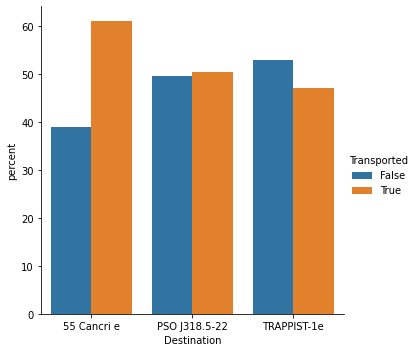

In [17]:
x,y = 'Destination', 'Transported'

(train.groupby(x)[y].value_counts(normalize=True).mul(100).rename('percent').reset_index().pipe((sns.catplot,'data'), x=x,y='percent',hue=y,kind='bar'))
plt.show()

* Passengers have high chances of getting transported to 55 Cancri destination, followed by PSO and Trappist

## Is there any relationship with VIP column

<AxesSubplot:xlabel='VIP', ylabel='count'>

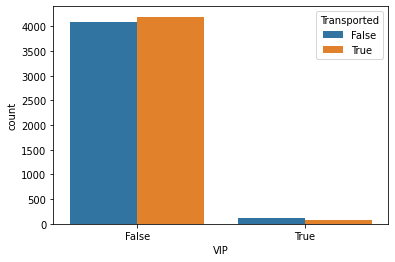

In [18]:
sns.countplot(x='VIP',data=train,hue='Transported')

* VIP is not saving at all

# 2. Numerical Data

In [19]:
train.select_dtypes(exclude='object').columns

Index(['Age', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck',
       'Transported'],
      dtype='object')

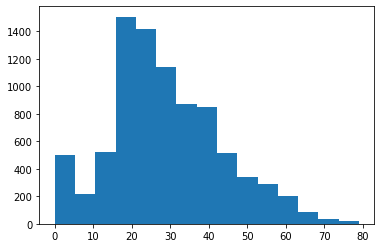

In [20]:
plt.hist(train['Age'],bins=15)
plt.show()

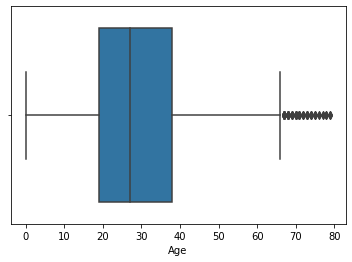

In [21]:
sns.boxplot(train['Age'])
plt.show()

<AxesSubplot:xlabel='Age', ylabel='Density'>

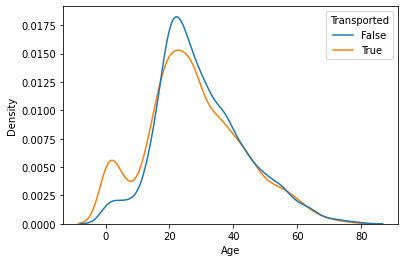

In [22]:
sns.kdeplot(train['Age'],hue=train['Transported'])

* Passengers under zero Age found to be transported!!We will remove them and try the plotting again
* Passengers age between 18-25 years found to be travelling more

A skewness value greater than 1 or less than -1 indicates a highly skewed distribution. A value between 0.5 and 1 or -0.5 and -1 is moderately skewed. A value between -0.5 and 0.5 indicates that the distribution is fairly symmetrical.

In [23]:
train['Age'].skew()

0.41909658301471536

Age distribution is fairly symmetric

In [24]:
train[['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']].sum()

RoomService    1912541.00
FoodCourt      3898237.00
ShoppingMall   1474092.00
Spa            2647791.00
VRDeck         2592790.00
dtype: float64

* Passengers spent more on FoodCourt followed by VRDeck and SPA.

In [25]:
train_copy=train.copy()
train_copy['Total_amount_spent']=train['RoomService']+train['FoodCourt']+train['ShoppingMall']+train['Spa']+train['VRDeck']

<AxesSubplot:xlabel='Age', ylabel='Total_amount_spent'>

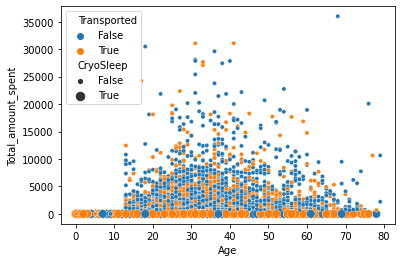

In [26]:
sns.scatterplot(x='Age',y='Total_amount_spent',data=train_copy,hue='Transported',size='CryoSleep')

* Obviously, passengers under cryosleep has not spent any penny and got trnasported more
* passengers above 70 whoever spent are having less chances of transporation

In [27]:
train.columns

Index(['PassengerId', 'HomePlanet', 'CryoSleep', 'Cabin', 'Destination', 'Age',
       'VIP', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck',
       'Name', 'Transported'],
      dtype='object')

As Passender ID is of no use, we will drop both of them from train and test

In [28]:
train.drop(columns=['PassengerId'],axis=1,inplace=True)
test.drop(columns=['PassengerId'],axis=1,inplace=True)

Let's go for some more  Numerical and categorical plots for more insights

<AxesSubplot:xlabel='HomePlanet', ylabel='Age'>

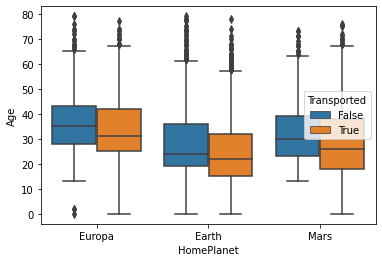

In [29]:
sns.boxplot(train['HomePlanet'],train['Age'],hue=train['Transported'])

* Passengers above 65 years old who were started from Mars have more chances of Transportation
* Passengers from earth having less than 30 years Age are more likely to being transported

In [30]:
# Plotting Pie Chart 
age = train.Age.value_counts()
age
fig = px.pie(train, values=age.values, names=age.index, title='Age of Passengers')
fig.update_traces(textposition='inside', textinfo='percent+label')
fig.show()

# Let's check correlation among variable

## Heat Maps are graphical representations of data that utilize color-coded systems. The primary purpose of Heat Maps is to better visualize the volume of locations/events within a dataset and assist in directing viewers towards areas on data visualizations that matter most.

<AxesSubplot:>

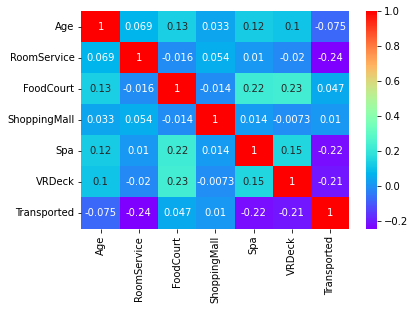

In [31]:
sns.heatmap(train.corr(),annot=True,cmap='rainbow')

* As expected, spending on services like Room service,Spa and VRdeck made chances of being transported very less
* But people who spent mainly on FoodCourt has good chances of transportation
* Room service vs shoppingmall and Age has positive correlation
* Age vs spendings on services has positive correlation too

## A cluster map is an intuitive way to group search results by topic. By identifying similar documents, it helps to better understand the structure of online coverage and other large document collections.

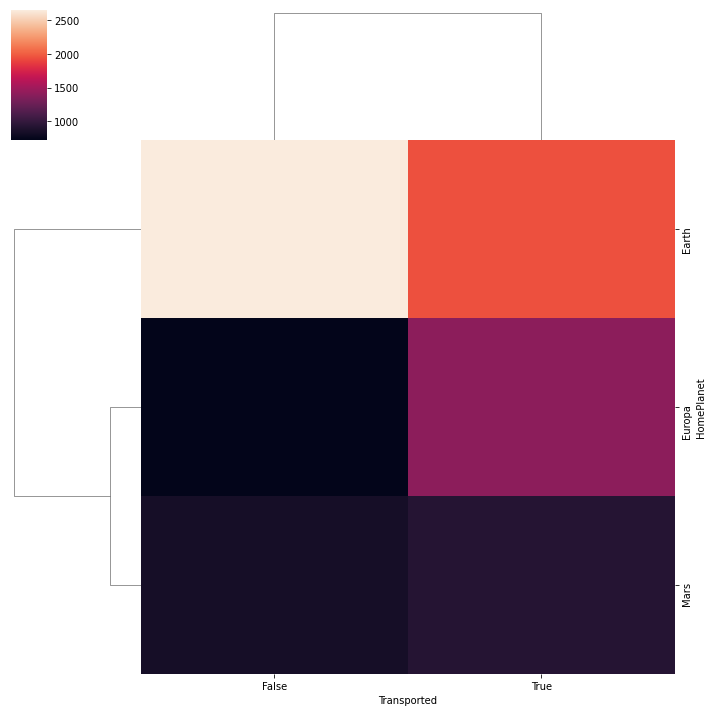

In [32]:
sns.clustermap(pd.crosstab(train['HomePlanet'],train['Transported']))

## Pair plot is used to understand the best set of features to explain a relationship between two variables or to form the most separated clusters. It also helps to form some simple classification models by drawing some simple lines or make linear separation in our data-set.

# Missing values treatment

In [33]:
numeric_data=[col for col in train.select_dtypes(['int','float'])]
categorical_data=[col for col in train.select_dtypes(exclude=['int','float'])]
test_numeric_data=[col for col in test.select_dtypes(['int','float'])]
test_categorical_data=[col for col in test.select_dtypes(exclude=['int','float'])]

#numerical columns null values replacement with median
for col in numeric_data:
    train[col].fillna(train[col].median(),inplace=True)
for col in test_numeric_data:
    test[col].fillna(test[col].median(),inplace=True)


#replace missing values in each categorical column with the most frequent value
for col in categorical_data:
    train[col].fillna(train[col].value_counts().index[0],inplace=True)
for col in test_categorical_data:
    test[col].fillna(test[col].value_counts().index[0],inplace=True)

# Encoding categorical Features

In [34]:
le=LabelEncoder()
train['HomePlanet']=le.fit_transform(train['HomePlanet'])
train['CryoSleep']=le.fit_transform(train['CryoSleep'])
train['Cabin']=le.fit_transform(train['Cabin'])
train['Destination']=le.fit_transform(train['Destination'])
train['VIP']=le.fit_transform(train['VIP'])
train['Transported']=le.fit_transform(train['Transported'])

In [35]:
train.drop(["Name" ,"Cabin"] , axis = 1 ,inplace = True)
test.drop(["Name" ,"Cabin"] , axis = 1 ,inplace = True)
X = train.drop('Transported' , axis =1 )
y = train['Transported']
X_train , X_test , y_train , y_test = train_test_split(X , 
                                                       y, 
                                                       random_state = 12 ,
                                                       test_size =0.33)

In [36]:
clf = LazyClassifier(verbose=0,
                     ignore_warnings=True,
                     custom_metric=None,
                     predictions=False,
                     random_state=12,
                     classifiers='all')

models, predictions = clf.fit(X_train , X_test , y_train , y_test)
clear_output()

In [37]:
models

,Accuracy,Balanced Accuracy,ROC AUC,F1 Score,Time Taken
Model,,,,,
LGBMClassifier,0.79,0.79,0.79,0.79,0.18
XGBClassifier,0.78,0.78,0.78,0.78,1.85
AdaBoostClassifier,0.78,0.78,0.78,0.78,0.27
RandomForestClassifier,0.77,0.77,0.77,0.77,0.78
SVC,0.77,0.77,0.77,0.77,1.86
LogisticRegression,0.77,0.77,0.77,0.77,0.05
ExtraTreesClassifier,0.77,0.77,0.77,0.77,0.64
NuSVC,0.77,0.77,0.77,0.77,2.30
LabelSpreading,0.77,0.77,0.77,0.77,1.52


# Accuracy vs model

In [38]:
line=px.line(data_frame=models,y=['Accuracy'],markers=True)
line.update_xaxes(title="Model",
              rangeslider_visible = False)
line.update_yaxes(title = "Accuracy")
line.update_traces(line_color="blue")
line.update_layout(showlegend = True,
    title = {
        'text': 'Accuracy vs Model',
        'y':0.94,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'})
line.show()

# ROC AUC vs F1 score vs Model

In [39]:
line = px.line(data_frame= models ,y =["ROC AUC" , "F1 Score"] , markers = True)
line.update_xaxes(title="Model",
              rangeslider_visible = False)
line.update_yaxes(title = "ROC AUC SCORE")
line.update_layout(showlegend = True,
    title = {
        'text': 'ROC AUC and F1 Score vs Model',
        'y':0.94,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'})

line.show()

# Time taken by each model

In [40]:

line = px.line(data_frame= models ,y =["Time Taken"] , markers = True)
line.update_xaxes(title="Model",
              rangeslider_visible = False)
line.update_yaxes(title = "Time(s)")
line.update_traces(line_color="purple")
line.update_layout(showlegend = True,
    title = {
        'text': 'TIME TAKEN vs Model',
        'y':0.94,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'})

line.show()

LGBM classifier is best interms of accuracy,ROC AUC, F1 score and time taken